# Forward prediction of Hindi sentiment(s) in CrowdTangle dataset

## Installs and imports

In [1]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 24.4 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 432.7/432.7 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 kB 9.8 MB/s eta 0:00:00
  Attempting unins

In [2]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties

from scipy.special import softmax
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

## Load the `CrowdTangle` dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv (
    '/content/drive/My Drive/The-London-Story/CrowdTangle-TLS-workspace/2022-07-11-16-34-58-CEST-Historical-Report-2016-12-31--2022-07-11.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=';', 
    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.shape

(604703, 40)

Because the size of the dataset is too large, let's choose `N` random entries from the dataframe

In [6]:
df = df.sample(n = 50000) # randomly select N entries

In [7]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Data preprocessing

Replace NaN values in particular columns with empty string

In [8]:
df.message = df.message.fillna('')
#df.description = df.description.fillna('')
#df.imageText = df.imageText.fillna('')

Extract particular columns and convert into lists

In [9]:
message_list = df ['message'].tolist()
#imageText_list = df ['imageText'].tolist()

print ("Total number of entries in the dataset:", len(message_list))

Total number of entries in the dataset: 50000


## Load the sentiment analysis model and the tokenizer


Define parameters

In [10]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 32

n_labels = 3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

max_length = 312

MODEL = "cardiffnlp/twitter-xlm-roberta-base-sentiment"

Load the model and the tokenizer

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

config = AutoConfig.from_pretrained(MODEL) # used for id to label name (optional)

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

if CUDA:
  model = model.to('cuda')
_ = model.eval()

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

## Define the forward prediction functions

In [12]:
def forward (text, cuda=True):
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = max_length)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

In [13]:
def sentiment_pred_score (data_list):
  dl = DataLoader(data_list, batch_size=BATCH_SIZE)
  sentiment_pred = []

  for idx, batch in enumerate(dl):
    print('Batch ',idx+1,' of ', len(dl))

    if (batch != ''):
      scores = forward(batch, cuda=CUDA)
      preds = np.argmax(scores, axis=-1)
    else:
      preds = 1
    sentiment_pred.extend(preds)
  
  return sentiment_pred

## Run sentiment prediction task on the dataset(s) and save the results

In [14]:
message_sentiment_score = sentiment_pred_score (message_list)

Batch  1  of  1563
Batch  2  of  1563
Batch  3  of  1563
Batch  4  of  1563
Batch  5  of  1563
Batch  6  of  1563
Batch  7  of  1563
Batch  8  of  1563
Batch  9  of  1563
Batch  10  of  1563
Batch  11  of  1563
Batch  12  of  1563
Batch  13  of  1563
Batch  14  of  1563
Batch  15  of  1563
Batch  16  of  1563
Batch  17  of  1563
Batch  18  of  1563
Batch  19  of  1563
Batch  20  of  1563
Batch  21  of  1563
Batch  22  of  1563
Batch  23  of  1563
Batch  24  of  1563
Batch  25  of  1563
Batch  26  of  1563
Batch  27  of  1563
Batch  28  of  1563
Batch  29  of  1563
Batch  30  of  1563
Batch  31  of  1563
Batch  32  of  1563
Batch  33  of  1563
Batch  34  of  1563
Batch  35  of  1563
Batch  36  of  1563
Batch  37  of  1563
Batch  38  of  1563
Batch  39  of  1563
Batch  40  of  1563
Batch  41  of  1563
Batch  42  of  1563
Batch  43  of  1563
Batch  44  of  1563
Batch  45  of  1563
Batch  46  of  1563
Batch  47  of  1563
Batch  48  of  1563
Batch  49  of  1563
Batch  50  of  1563
Batch  51

Append the prediction scores to the original pandas dataframe

In [15]:
df ['messageSentiment.score'] = message_sentiment_score
#df ['imageTextSentiment.score'] = imageText_sentiment_score

In [16]:
df.head()

,account.name,account.handle,platformId,Page Category,Page Admin Top Country,Page Description,Page Created,subscriberCount,Followers at Posting,date,...,expandedLinks.original,expandedLinks.expanded,imageText,title,description,brandedContentSponsor.platformId,brandedContentSponsor.name,brandedContentSponsor.category,score,messageSentiment.score
64702,We support hindutva,Wesupportbhagwa,100050581355540,POLITICIAN,IN,सिर्फ हिन्दू ही जुड़े हमारे पेज से ।ज?,2018-08-08 19:54:34,178199.0,238634.0,2022-04-05 12:04:17 CEST,...,https://sachkhabar.co.in/sushant-singh-rajputs...,NaN,NaN,Sushant Singh Rajput की गर्लफ्रेंड रिया चक्रवर...,बॉलीवुड इंडस्ट्री के मशहूर अभिनेता सुशांत सिंह...,NaN,NaN,NaN,-4.6,1
547171,Mission Hindu Ekta,NaN,100063522952751,POLITICIAN,IN,राष्ट्राय स्वाहा । इदम् राष्ट्राय न म?,2018-05-13 12:28:45,NaN,NaN,2019-03-01 08:03:28 CET,...,https://www.amarujala.com/india-news/lok-sabha...,NaN,NaN,This is a re-share of a post,अमित शाह ने कहा कि तीन दिन बाद अगर मैंने पाकिस...,NaN,NaN,NaN,-0.75,0
552156,Suresh Norva,sureshnorva,100050215761608,PERSON,IN,https://youtube.com/c/sureshnorva,2013-12-31 10:51:44,NaN,NaN,2019-01-27 15:46:54 CET,...,https://www.facebook.com/sureshnorva/photos/a....,NaN,NaN,Photos from Suresh Norva's post,NaN,NaN,NaN,NaN,-13.32,0
459574,Pushpendra Kulshrestha Fans Club,Pushpendrarss,313739616231431,ACTIVITY_GENERAL,IN,"पेज से जुड़ने के लिए आपका धन्यवाद, आशा करते है ...",2019-06-07 08:59:33,257465.0,355205.0,2020-05-29 07:15:13 CEST,...,https://humlog.co.in/signs-of-corona-found-in-...,NaN,NaN,"संबित पात्रा में पाया गया कोरोना का लक्षण,ये स...",टीवी डिबेट का जाना माना चेहरा संबित पात्रा जो ...,NaN,NaN,NaN,7.57,0
331799,मोदी फैन्स टीम,NaN,149851822355932,ART,IN,Art,2018-03-02 15:24:28,55724.0,59188.0,2021-05-06 18:43:48 CEST,...,https://www.facebook.com/149851822355932/photo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.03,0


Save the dataframe (along with the results)

In [17]:
df.to_csv('/content/drive/MyDrive/CT_sentiment.csv', index=False)

## Visualization of the results

Histograms of the predicted scores

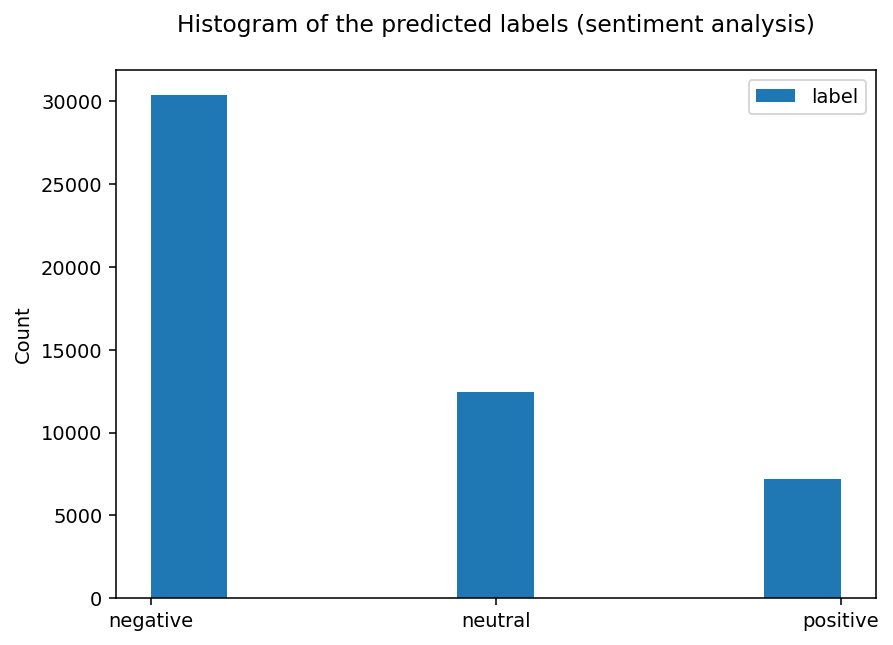

In [29]:
x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots (figsize=(7, 5), dpi=140)
plt.title ('Histogram of the predicted labels (sentiment analysis)\n')
plt.hist (df ['messageSentiment.score'], bins, label=['label'] )
ax.set_ylabel ('Count')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.legend (loc='upper right')
plt.show ()

Bar plot of top actors

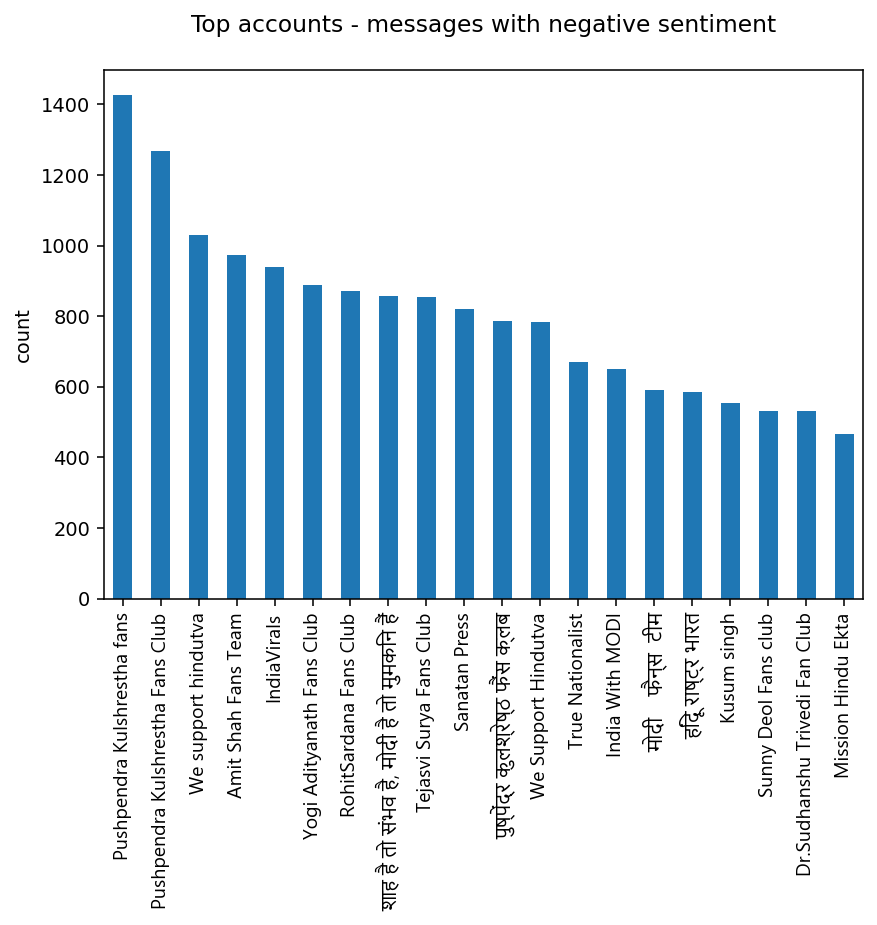

In [30]:
plt.figure(figsize=(7,5),dpi=140)

negative_sentiment = df [df['messageSentiment.score'] == 0]
negative_sentiment ['account.name'].value_counts()[:20].plot(kind='bar')

# Customize matplotlib
hindi_font = FontProperties(fname = '/content/drive/MyDrive/The-London-Story/Nirmala.ttf')

plt.xticks(fontproperties=hindi_font)
#plt.xticks(rotation = 60)

plt.title('Top accounts - messages with negative sentiment\n')
plt.ylabel('count')

plt.show()